In [1]:
import torch, os
import torch.nn as nn
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random
import torch.utils.data as torchdata
from torch.utils.data import SubsetRandomSampler
# from train_model import train_model
# from test_model import test_model
%matplotlib inline

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]='1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
filePath = '/local/rcs/ll3504/datasets/256_ObjectCategories/'
namelist = os.listdir(filePath)
nameDic_cal = {}
for name in namelist:
    splits = name.split(".")
    nameDic_cal[int(splits[0])-1] = splits[1]
print(nameDic_cal[1])

american-flag


In [4]:
def get_dataset(path='/database', dataset_name='caltech-256-common'):
    # No holdout testing data. train and test data are the same, but different transformation
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize([256, 256]),
            transforms.RandomCrop(224),
            transforms.RandomRotation(20),
            transforms.RandomHorizontalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    }

    tr_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['train'])
    te_dataset = datasets.ImageFolder(path + dataset_name + '/', data_transforms['test'])
#     print('{} train set size: {}'.format(dataset_name, len(tr_dataset)))
#     print('{} test set size: {}'.format(dataset_name, len(te_dataset)))

    return tr_dataset, te_dataset

In [5]:
def split_dataset(train_dataset, test_dataset, valid_size=0.2, batch_size=128, train_size = 128):
    '''
    This function shuffles the dataset, 
    splits dataset into train, val, and test sets, and return train, val, test dataloaders.
    
    Val and Test loaders are the same

    '''
    
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    random.shuffle(indices)
    train_idx, valid_idx = indices[split:split+train_size], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
#     print("DEBUGGING: the train_ind are:", len(train_idx))


    train_loader = torchdata.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=48, pin_memory=True, drop_last=True, sampler = train_sampler)
    test_loader = torchdata.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=48, pin_memory=True, drop_last=True, sampler = valid_sampler)
    dataloaders = {'train': train_loader,
                   'val': test_loader,
                   'test': test_loader}
    dataset_sizes ={'train': train_size, #int(np.floor((1-valid_size) * num_train)),
                    'val': int(np.floor(valid_size * num_train)),
                    'test': int(np.floor(valid_size * num_train))}
    return dataloaders, dataset_sizes

In [6]:
imagebase = '/local/rcs/ll3504/datasets/'

In [7]:
corruption = ['zoom_blur', 'speckle_noise', 'spatter',
                       'snow', 'glass_blur', 'motion_blur', 'saturate',
                       'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast',
                       'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']

# ImageNetC

In [8]:
def get_imagenetc(imagebase, severity=1, batch_size=128, sample_size = 128):
    '''
    Returns:
        ref_dataloaders:          ImageNet original validation data, as a reference
        ref_dataset_sizes:        1000, not the sizes of the real dataset in the ref_loader, probs used downstream
        corrupted_dataloaders:    A list of corrupted dataloaders, each element in a list represetns the data loaders
                                  for one corruption type. Each element contains ['train']['val']['test'] loaders
        corrupted_dataset_sizes:  A list of dictionaries of the sizes of each loaders for each corruption
        corruption:               A list of corruption names, in the same order of the corrupted_dataloaders
    '''
    corruption = ['zoom_blur', 'speckle_noise', 'spatter',
                       'snow', 'glass_blur', 'motion_blur', 'saturate',
                       'gaussian_blur', 'frost', 'fog', 'brightness', 'contrast',
                       'elastic_transform', 'pixelate', 'jpeg_compression', 'defocus_blur']
    corrupted_dataloaders = []
    corrupted_dataset_sizes = []
    
    # this is the imageNet validation data
    imagenet_val = datasets.ImageNet(imagebase+'imagenetc/', split='val', transform=transforms.Compose([
            transforms.Resize([224, 224]),
            transforms.CenterCrop((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ]),
                                   target_transform=None)#, download=False)
    
    # print("DEBUGGING: imagenet_val size is:", len(imagenet_val))
    
    random_indices = random.sample(range(0, len(imagenet_val)), int(len(imagenet_val)*0.02))
    # print("DEBUGGING: random indices are:", len(random_indices))
    imagenet_val_subset = data.Subset(imagenet_val, random_indices)
    val_loader = torch.utils.data.DataLoader(imagenet_val_subset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=48)
    ref_dataloaders = { 'val': val_loader,
                       'test': val_loader}
    ref_dataset_sizes ={'val': int(len(val_loader.dataset)),
                        'test': int(len(val_loader.dataset))}
    
    # for every type of corruption, go to the specified severity folder
    for corr in corruption:
        dataset_name = 'imagenetc/' + corr + '/' + str(severity)
        # Get dataset from folder
        corr_trian_images, corr_test_images = get_dataset(imagebase, dataset_name)
        # get corruption-specific train, val, test loader
        # train: training data, non-overlap with val/test
        # val: non-overlap with train, same as test
        # test: non-overlap with train, same as val
        corr_dataloaders, corr_dataset_sizes = split_dataset(corr_trian_images, corr_test_images, valid_size=0.02, batch_size=batch_size, train_size=sample_size)
        corrupted_dataloaders.append(corr_dataloaders)
        corrupted_dataset_sizes.append(corr_dataset_sizes)
    return ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption

In [ ]:
ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
= get_imagenetc(imagebase, 5, 32, 32)



In [63]:
# in total 16 corruptions, each have 3 dataloaders ['train']['val']['test']
len(corrupted_dataloaders[15]['val']) # why is this 31??

31

In [33]:
corrupted_dataset_sizes[0]

{'train': 32, 'val': 1000, 'test': 1000}

In [45]:
ref_dataset_sizes['val']

1000

In [59]:
len(ref_dataloaders['val'])

32

# Robust Pseudo label

In [9]:
import torch
from torchvision import models, datasets, transforms

def gce(logits, target, q = 0.8):
    """ Generalized cross entropy.
    
    Reference: https://arxiv.org/abs/1805.07836
    """
    probs = torch.nn.functional.softmax(logits, dim=1)
    probs_with_correct_idx = probs.index_select(-1, target).diag()
    loss = (1. - probs_with_correct_idx**q) / q
    return loss.mean()

def adapt_batchnorm(model):
    model.eval()
    parameters = []
    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            parameters.extend(module.parameters())
            module.train()
    return parameters


# ---



In [10]:
with open('RPL_corrupt_train_acc.npy', 'rb') as f:
    rpl_corrupt_train_acc = np.load(f)
with open('RPL_corrupt_validation_acc.npy', 'rb') as f:
    rpl_corrupt_val_acc = np.load(f)
with open('RPL_target_acc.npy', 'rb') as f:
    rpl_ref_acc = np.load(f)
with open('RPL_adapt_time.npy', 'rb') as f:
    rpl_adpt_times = np.load(f)


# Few-shot adaptation

In [11]:
import time

In [12]:
def few_shot_adapt(
#         datadir = '/data/imagenetc/gaussian_blur/3',
        basline,
        model,
        dataloader,
        num_epochs = 1, # followed their findings in the paper
        batch_size = 32,
        learning_rate = 0.75e-3,
        gce_q = 0.8,
    ):
    
    # model = models.resnet50(pretrained = True).to(device)
    parameters = adapt_batchnorm(model)
    # TODO change this loader
    # val_loader = get_dataset_loader(
    #    datadir,
    #    batch_size = batch_size,
    #    shuffle = True
    #)
    
    optimizer = torch.optim.SGD(
        model.parameters(), lr = learning_rate
    )
    
    b_correct, num_correct, num_samples = 0., 0., 0.
    for epoch in range(num_epochs):
        predictions = []
        batch_accs = []
        for images, labels in dataloader:
            # start = time.time()
            # print(f"DEBUGGING: num_samples = {num_samples}")
            outputs = model(images.to(device))
            predictions = outputs.argmax(dim = 1)

            # _, predicted = torch.max(outputs.data, 1)
            # inference_time = time.time() - start

            # TODO: in our scenario, do we want to revert back to original model after adapting in each step?
            loss = gce(outputs, predictions, q = gce_q)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # probably shouldn't do this here, because model not in eval mode. 
            # TODO: Think about how to set up few-shot experiments
            outputs = model(images.to(device))
            predictions = outputs.argmax(dim = 1)
            
                    
            b_outputs = baseline(images.to(device))
            b_predictions = b_outputs.argmax(dim = 1)
            

            num_correct += (predictions.detach().cpu() == labels).float().sum()
            num_samples += len(labels)
            
            b_correct += (b_predictions.detach().cpu() == labels).float().sum()
            #print(f"DEBUGGING: len(labels) = {len(labels)}")

    
    print(f"Baseline Correct: {b_correct:#5.0f}/{num_samples:#5.0f} ({100 * b_correct / num_samples:.2f} %)")
    print(f"Adapt Correct: {num_correct:#5.0f}/{num_samples:#5.0f} ({100 * num_correct / num_samples:.2f} %)")
    
    return num_correct/num_samples, b_correct/num_samples
            


In [14]:
shot_sizes = [1, 5, 10, 20, 32]
severity = [1,2,3,4,5]

rpl_few_shot_acc = np.zeros(shape=(len(corruption), len(severity), len(shot_sizes)))
base_few_shot_acc = np.zeros(shape=(len(corruption), len(severity), len(shot_sizes)))

rpl_few_shot_acc.shape

(16, 5, 5)

In [15]:
# test on 1000 datapoints within
baseline = models.resnet50(pretrained=True)
baseline.to(device)
baseline.eval()
for severity_ind in range(len(severity)):
    for ss_ind in range(len(shot_sizes)):
        ref_dataloaders, ref_dataset_sizes, corrupted_dataloaders, corrupted_dataset_sizes, corruption \
        = get_imagenetc(imagebase, severity[severity_ind], shot_sizes[ss_ind], 500)


            print(f'## Experiment: Severity = {severity[severity_ind]}, corruption = {corruption[cor_ind]}, shot_size = {shot_sizes[ss_ind]}')
            # one_shot_accs = []

            model = models.resnet50(pretrained=True)
            model.to(device)


            # adapt the model
            # start = time.time()
            training_acc, basline_acc = few_shot_adapt(baseline, model, corrupted_dataloaders[cor_ind]['train'])
            # adapt_time = time.time() - start
            # print(f"Adaptation time: {adapt_time}")
            print(f'One_shot_accuracies is: {training_acc} and Baseline accuracy is: {basline_acc}' )

            # rpl_one_shot_adpt_times[cor_ind, severity_ind] = one_shot_accs.mean()
            rpl_few_shot_acc[cor_ind, severity_ind, ss_ind] = training_acc.numpy()
            base_few_shot_acc[cor_ind, severity_ind, ss_ind] = basline_acc.numpy()


        with open('rpl_few_shot_acc.npy', 'wb') as f:
            np.save(f, rpl_few_shot_acc)
        with open('base_few_shot_acc.npy', 'wb') as f:
            np.save(f, base_few_shot_acc)
    #         with open('RPL_target_acc.npy', 'wb') as f:
    #             np.save(f, rpl_ref_acc)
    #     with open('rpl_one_shot_adpt_times.npy', 'wb') as f:
    #         np.save(f, rpl_one_shot_adpt_times)





## Experiment: Severity = 1, corruption = zoom_blur, shot_size = 1
Baseline Correct:    0./ 500. (0.00 %)
Adapt Correct:    0./ 500. (0.00 %)
One_shot_accuracies is: 0.0 and Baseline accuracy is: 0.0
## Experiment: Severity = 1, corruption = speckle_noise, shot_size = 1
Baseline Correct:    1./ 500. (0.20 %)
Adapt Correct:    1./ 500. (0.20 %)
One_shot_accuracies is: 0.0020000000949949026 and Baseline accuracy is: 0.0020000000949949026
## Experiment: Severity = 1, corruption = spatter, shot_size = 1
Baseline Correct:    1./ 500. (0.20 %)
Adapt Correct:    1./ 500. (0.20 %)
One_shot_accuracies is: 0.0020000000949949026 and Baseline accuracy is: 0.0020000000949949026
## Experiment: Severity = 1, corruption = snow, shot_size = 1
Baseline Correct:    0./ 500. (0.00 %)
Adapt Correct:    0./ 500. (0.00 %)
One_shot_accuracies is: 0.0 and Baseline accuracy is: 0.0
## Experiment: Severity = 1, corruption = glass_blur, shot_size = 1
Baseline Correct:    2./ 500. (0.40 %)
Adapt Correct:    0./ 50

Baseline Correct:  168./ 500. (33.60 %)
Adapt Correct:  174./ 500. (34.80 %)
One_shot_accuracies is: 0.3479999899864197 and Baseline accuracy is: 0.335999995470047
## Experiment: Severity = 1, corruption = motion_blur, shot_size = 10
Baseline Correct:  199./ 500. (39.80 %)
Adapt Correct:  201./ 500. (40.20 %)
One_shot_accuracies is: 0.4020000100135803 and Baseline accuracy is: 0.39800000190734863
## Experiment: Severity = 1, corruption = saturate, shot_size = 10
Baseline Correct:  280./ 500. (56.00 %)
Adapt Correct:  277./ 500. (55.40 %)
One_shot_accuracies is: 0.5540000200271606 and Baseline accuracy is: 0.5600000023841858
## Experiment: Severity = 1, corruption = gaussian_blur, shot_size = 10
Baseline Correct:  212./ 500. (42.40 %)
Adapt Correct:  218./ 500. (43.60 %)
One_shot_accuracies is: 0.4359999895095825 and Baseline accuracy is: 0.42399999499320984
## Experiment: Severity = 1, corruption = frost, shot_size = 10
Baseline Correct:  235./ 500. (47.00 %)
Adapt Correct:  248./ 500.

Baseline Correct:  245./ 480. (51.04 %)
Adapt Correct:  245./ 480. (51.04 %)
One_shot_accuracies is: 0.5104166865348816 and Baseline accuracy is: 0.5104166865348816
## Experiment: Severity = 1, corruption = frost, shot_size = 32
Baseline Correct:  226./ 480. (47.08 %)
Adapt Correct:  226./ 480. (47.08 %)
One_shot_accuracies is: 0.47083333134651184 and Baseline accuracy is: 0.47083333134651184
## Experiment: Severity = 1, corruption = fog, shot_size = 32
Baseline Correct:  228./ 480. (47.50 %)
Adapt Correct:  229./ 480. (47.71 %)
One_shot_accuracies is: 0.47708332538604736 and Baseline accuracy is: 0.4749999940395355
## Experiment: Severity = 1, corruption = brightness, shot_size = 32
Baseline Correct:  284./ 480. (59.17 %)
Adapt Correct:  284./ 480. (59.17 %)
One_shot_accuracies is: 0.5916666388511658 and Baseline accuracy is: 0.5916666388511658
## Experiment: Severity = 1, corruption = contrast, shot_size = 32
Baseline Correct:  230./ 480. (47.92 %)
Adapt Correct:  232./ 480. (48.33 %

Baseline Correct:  119./ 500. (23.80 %)
Adapt Correct:  119./ 500. (23.80 %)
One_shot_accuracies is: 0.23800000548362732 and Baseline accuracy is: 0.23800000548362732
## Experiment: Severity = 2, corruption = pixelate, shot_size = 5
Baseline Correct:  198./ 500. (39.60 %)
Adapt Correct:  200./ 500. (40.00 %)
One_shot_accuracies is: 0.4000000059604645 and Baseline accuracy is: 0.3959999978542328
## Experiment: Severity = 2, corruption = jpeg_compression, shot_size = 5
Baseline Correct:  148./ 500. (29.60 %)
Adapt Correct:  153./ 500. (30.60 %)
One_shot_accuracies is: 0.3059999942779541 and Baseline accuracy is: 0.29600000381469727
## Experiment: Severity = 2, corruption = defocus_blur, shot_size = 5
Baseline Correct:   90./ 500. (18.00 %)
Adapt Correct:   98./ 500. (19.60 %)
One_shot_accuracies is: 0.19599999487400055 and Baseline accuracy is: 0.18000000715255737
## Experiment: Severity = 2, corruption = zoom_blur, shot_size = 10
Baseline Correct:  153./ 500. (30.60 %)
Adapt Correct:  1

Baseline Correct:  135./ 500. (27.00 %)
Adapt Correct:  146./ 500. (29.20 %)
One_shot_accuracies is: 0.2919999957084656 and Baseline accuracy is: 0.27000001072883606
## Experiment: Severity = 2, corruption = zoom_blur, shot_size = 32
Baseline Correct:  150./ 480. (31.25 %)
Adapt Correct:  152./ 480. (31.67 %)
One_shot_accuracies is: 0.3166666626930237 and Baseline accuracy is: 0.3125
## Experiment: Severity = 2, corruption = speckle_noise, shot_size = 32
Baseline Correct:  201./ 480. (41.88 %)
Adapt Correct:  202./ 480. (42.08 %)
One_shot_accuracies is: 0.4208333194255829 and Baseline accuracy is: 0.41874998807907104
## Experiment: Severity = 2, corruption = spatter, shot_size = 32
Baseline Correct:  228./ 480. (47.50 %)
Adapt Correct:  229./ 480. (47.71 %)
One_shot_accuracies is: 0.47708332538604736 and Baseline accuracy is: 0.4749999940395355
## Experiment: Severity = 2, corruption = snow, shot_size = 32
Baseline Correct:  100./ 480. (20.83 %)
Adapt Correct:   99./ 480. (20.62 %)
One

Baseline Correct:   92./ 500. (18.40 %)
Adapt Correct:   93./ 500. (18.60 %)
One_shot_accuracies is: 0.1860000044107437 and Baseline accuracy is: 0.18400000035762787
## Experiment: Severity = 3, corruption = glass_blur, shot_size = 5
Baseline Correct:   52./ 500. (10.40 %)
Adapt Correct:   53./ 500. (10.60 %)
One_shot_accuracies is: 0.10599999874830246 and Baseline accuracy is: 0.10400000214576721
## Experiment: Severity = 3, corruption = motion_blur, shot_size = 5
Baseline Correct:   76./ 500. (15.20 %)
Adapt Correct:   81./ 500. (16.20 %)
One_shot_accuracies is: 0.16200000047683716 and Baseline accuracy is: 0.15199999511241913
## Experiment: Severity = 3, corruption = saturate, shot_size = 5
Baseline Correct:  217./ 500. (43.40 %)
Adapt Correct:  222./ 500. (44.40 %)
One_shot_accuracies is: 0.4440000057220459 and Baseline accuracy is: 0.4339999854564667
## Experiment: Severity = 3, corruption = gaussian_blur, shot_size = 5
Baseline Correct:   65./ 500. (13.00 %)
Adapt Correct:   63./

Baseline Correct:  105./ 500. (21.00 %)
Adapt Correct:  111./ 500. (22.20 %)
One_shot_accuracies is: 0.22200000286102295 and Baseline accuracy is: 0.20999999344348907
## Experiment: Severity = 3, corruption = frost, shot_size = 20
Baseline Correct:  108./ 500. (21.60 %)
Adapt Correct:  109./ 500. (21.80 %)
One_shot_accuracies is: 0.21799999475479126 and Baseline accuracy is: 0.2160000056028366
## Experiment: Severity = 3, corruption = fog, shot_size = 20
Baseline Correct:  184./ 500. (36.80 %)
Adapt Correct:  189./ 500. (37.80 %)
One_shot_accuracies is: 0.3779999911785126 and Baseline accuracy is: 0.36800000071525574
## Experiment: Severity = 3, corruption = brightness, shot_size = 20
Baseline Correct:  251./ 500. (50.20 %)
Adapt Correct:  255./ 500. (51.00 %)
One_shot_accuracies is: 0.5099999904632568 and Baseline accuracy is: 0.5019999742507935
## Experiment: Severity = 3, corruption = contrast, shot_size = 20
Baseline Correct:  143./ 500. (28.60 %)
Adapt Correct:  153./ 500. (30.60 

Baseline Correct:    1./ 500. (0.20 %)
Adapt Correct:    0./ 500. (0.00 %)
One_shot_accuracies is: 0.0 and Baseline accuracy is: 0.0020000000949949026
## Experiment: Severity = 4, corruption = pixelate, shot_size = 1
Baseline Correct:    2./ 500. (0.40 %)
Adapt Correct:    2./ 500. (0.40 %)
One_shot_accuracies is: 0.004000000189989805 and Baseline accuracy is: 0.004000000189989805
## Experiment: Severity = 4, corruption = jpeg_compression, shot_size = 1
Baseline Correct:    1./ 500. (0.20 %)
Adapt Correct:    0./ 500. (0.00 %)
One_shot_accuracies is: 0.0 and Baseline accuracy is: 0.0020000000949949026
## Experiment: Severity = 4, corruption = defocus_blur, shot_size = 1
Baseline Correct:    0./ 500. (0.00 %)
Adapt Correct:    1./ 500. (0.20 %)
One_shot_accuracies is: 0.0020000000949949026 and Baseline accuracy is: 0.0
## Experiment: Severity = 4, corruption = zoom_blur, shot_size = 5
Baseline Correct:   93./ 500. (18.60 %)
Adapt Correct:   89./ 500. (17.80 %)
One_shot_accuracies is: 0.

## Experiment: Severity = 4, corruption = zoom_blur, shot_size = 20
Baseline Correct:  122./ 500. (24.40 %)
Adapt Correct:  123./ 500. (24.60 %)
One_shot_accuracies is: 0.2460000067949295 and Baseline accuracy is: 0.24400000274181366
## Experiment: Severity = 4, corruption = speckle_noise, shot_size = 20
Baseline Correct:  113./ 500. (22.60 %)
Adapt Correct:  113./ 500. (22.60 %)
One_shot_accuracies is: 0.22599999606609344 and Baseline accuracy is: 0.22599999606609344
## Experiment: Severity = 4, corruption = spatter, shot_size = 20
Baseline Correct:  147./ 500. (29.40 %)
Adapt Correct:  149./ 500. (29.80 %)
One_shot_accuracies is: 0.2980000078678131 and Baseline accuracy is: 0.2939999997615814
## Experiment: Severity = 4, corruption = snow, shot_size = 20
Baseline Correct:   88./ 500. (17.60 %)
Adapt Correct:   89./ 500. (17.80 %)
One_shot_accuracies is: 0.17800000309944153 and Baseline accuracy is: 0.17599999904632568
## Experiment: Severity = 4, corruption = glass_blur, shot_size = 

Baseline Correct:    1./ 500. (0.20 %)
Adapt Correct:    0./ 500. (0.00 %)
One_shot_accuracies is: 0.0 and Baseline accuracy is: 0.0020000000949949026
## Experiment: Severity = 5, corruption = motion_blur, shot_size = 1
Baseline Correct:    0./ 500. (0.00 %)
Adapt Correct:    0./ 500. (0.00 %)
One_shot_accuracies is: 0.0 and Baseline accuracy is: 0.0
## Experiment: Severity = 5, corruption = saturate, shot_size = 1
Baseline Correct:    0./ 500. (0.00 %)
Adapt Correct:    0./ 500. (0.00 %)
One_shot_accuracies is: 0.0 and Baseline accuracy is: 0.0
## Experiment: Severity = 5, corruption = gaussian_blur, shot_size = 1
Baseline Correct:    0./ 500. (0.00 %)
Adapt Correct:    1./ 500. (0.20 %)
One_shot_accuracies is: 0.0020000000949949026 and Baseline accuracy is: 0.0
## Experiment: Severity = 5, corruption = frost, shot_size = 1
Baseline Correct:    1./ 500. (0.20 %)
Adapt Correct:    1./ 500. (0.20 %)
One_shot_accuracies is: 0.0020000000949949026 and Baseline accuracy is: 0.00200000009499

Baseline Correct:   75./ 500. (15.00 %)
Adapt Correct:   76./ 500. (15.20 %)
One_shot_accuracies is: 0.15199999511241913 and Baseline accuracy is: 0.15000000596046448
## Experiment: Severity = 5, corruption = fog, shot_size = 10
Baseline Correct:   90./ 500. (18.00 %)
Adapt Correct:   96./ 500. (19.20 %)
One_shot_accuracies is: 0.19200000166893005 and Baseline accuracy is: 0.18000000715255737
## Experiment: Severity = 5, corruption = brightness, shot_size = 10
Baseline Correct:  197./ 500. (39.40 %)
Adapt Correct:  202./ 500. (40.40 %)
One_shot_accuracies is: 0.40400001406669617 and Baseline accuracy is: 0.39399999380111694
## Experiment: Severity = 5, corruption = contrast, shot_size = 10
Baseline Correct:   12./ 500. (2.40 %)
Adapt Correct:   14./ 500. (2.80 %)
One_shot_accuracies is: 0.02800000086426735 and Baseline accuracy is: 0.024000000208616257
## Experiment: Severity = 5, corruption = elastic_transform, shot_size = 10
Baseline Correct:  124./ 500. (24.80 %)
Adapt Correct:  126

Baseline Correct:   13./ 480. (2.71 %)
Adapt Correct:   13./ 480. (2.71 %)
One_shot_accuracies is: 0.02708333358168602 and Baseline accuracy is: 0.02708333358168602
## Experiment: Severity = 5, corruption = elastic_transform, shot_size = 32
Baseline Correct:  135./ 480. (28.12 %)
Adapt Correct:  138./ 480. (28.75 %)
One_shot_accuracies is: 0.2874999940395355 and Baseline accuracy is: 0.28125
## Experiment: Severity = 5, corruption = pixelate, shot_size = 32
Baseline Correct:  120./ 480. (25.00 %)
Adapt Correct:  123./ 480. (25.62 %)
One_shot_accuracies is: 0.2562499940395355 and Baseline accuracy is: 0.25
## Experiment: Severity = 5, corruption = jpeg_compression, shot_size = 32
Baseline Correct:   78./ 480. (16.25 %)
Adapt Correct:   83./ 480. (17.29 %)
One_shot_accuracies is: 0.17291666567325592 and Baseline accuracy is: 0.16249999403953552
## Experiment: Severity = 5, corruption = defocus_blur, shot_size = 32
Baseline Correct:   38./ 480. (7.92 %)
Adapt Correct:   40./ 480. (8.33 %)

In [32]:
rpl_few_shot_acc

array([[[0.002     , 0.34599999, 0.384     , 0.38787878, 0.366     ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.31400001, 0.426     , 0.45252526, 0.46000001,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
  

In [33]:
base_few_shot_acc

array([[[0.004     , 0.33199999, 0.36399999, 0.37171718, 0.354     ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.294     , 0.41800001, 0.44444445, 0.44800001,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
  

# Graphs

In [17]:
import matplotlib.pyplot as plt

In [55]:
with open('ResNet50_performances.npy', 'rb') as f:
    baseline_performances = np.load(f)
with open('ResNet50_times.npy', 'rb') as f:
    baseline_inf_times = np.load(f)
with open('RPL_corrupt_train_acc.npy', 'rb') as f:
    rpl_corrupt_train_acc = np.load(f)
with open('RPL_corrupt_validation_acc.npy', 'rb') as f:
    rpl_corrupt_val_acc = np.load(f)
with open('RPL_target_acc.npy', 'rb') as f:
    rpl_ref_acc = np.load(f)
with open('RPL_adapt_time.npy', 'rb') as f:
    rpl_adpt_times = np.load(f)


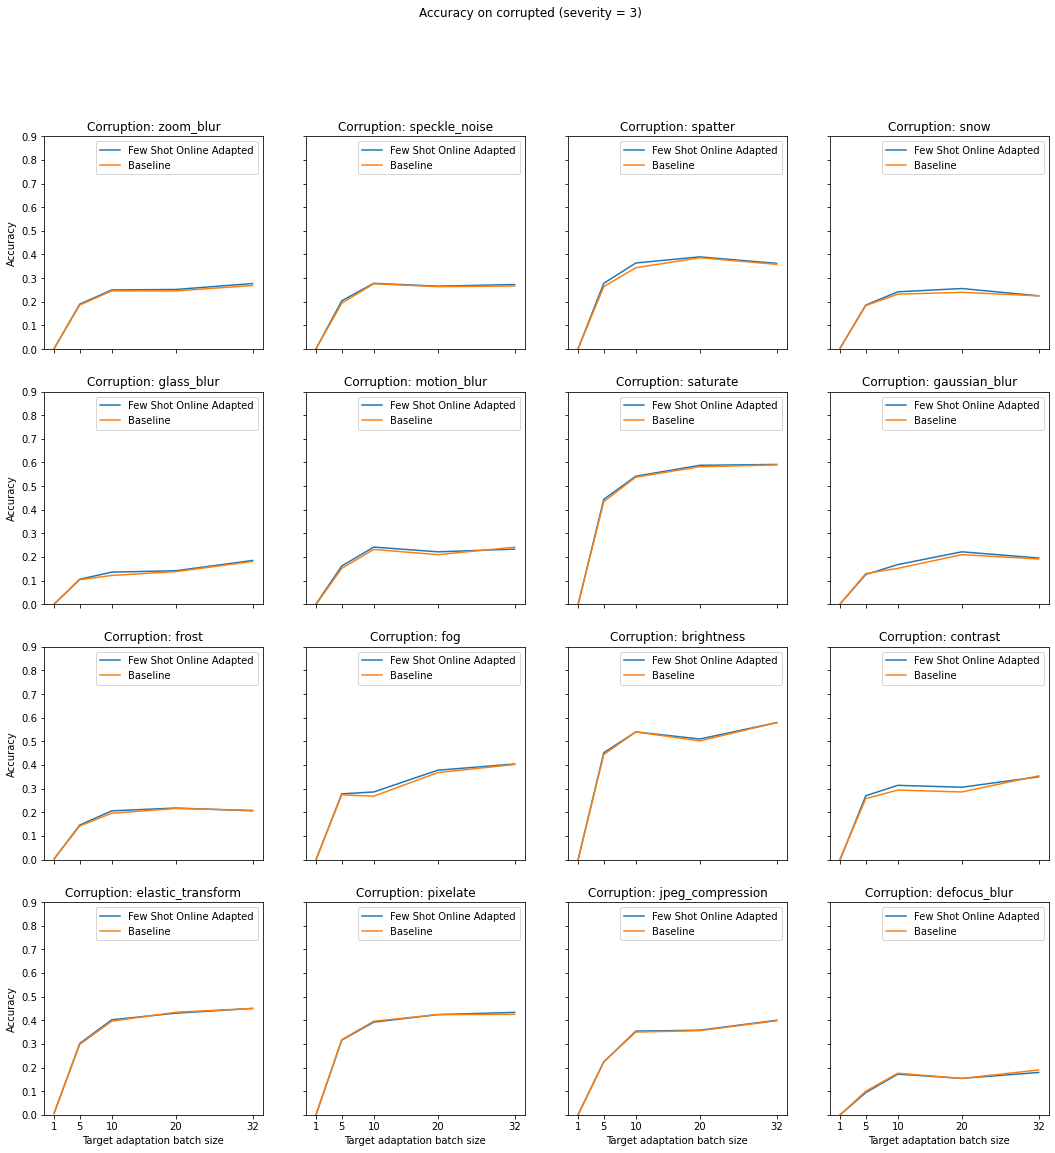

In [20]:
fig, ax = plt.subplots(4,4, figsize=(18, 18))
fig.suptitle('Accuracy on corrupted (severity = 3)')
for cor_ind in range(len(corruption)):
    
    ax[cor_ind//4][cor_ind%4].plot(shot_sizes, rpl_few_shot_acc[cor_ind][2], label='Few Shot Online Adapted')
    ax[cor_ind//4][cor_ind%4].plot(shot_sizes, base_few_shot_acc[cor_ind][2], label = 'Baseline')
    
    ax[cor_ind//4][cor_ind%4].legend()
    ax[cor_ind//4][cor_ind%4].set_title('Corruption: '+corruption[cor_ind])
    ax[cor_ind//4][cor_ind%4].set_xticks(shot_sizes)
    ax[cor_ind//4][cor_ind%4].set_ylim([0, 0.9])


    
for a in ax.flat:
    a.set(xlabel='Target adaptation batch size', ylabel='Accuracy')
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()

In [68]:
baseline_performances[1][2][0].repeat(8)

array([0.35483871, 0.35483871, 0.35483871, 0.35483871, 0.35483871,
       0.35483871, 0.35483871, 0.35483871])